# How long does an addition-deletion prcess take to converge?

[Simon Dobson](maiilto:simon.dobson@st-andrews.ac.uk)

## Summary

An addition-deletion process, as specified by Moore *et alia*, destroys some or all of the topological information in the original network. But how long does this take to happen?

In [1]:
from collections import Counter
from scipy.stats import chisquare
from mpmath import gammainc
from numpy.random import default_rng, shuffle
from numpy import exp
from pandas import DataFrame
from networkx import degree_histogram, fast_gnp_random_graph
from epyc import ParallelLab, HDF5LabNotebook, Experiment
from epydemic import ERNetwork, PLCNetwork, Process, AddDelete, NetworkStatistics, ProcessSequence, StochasticDynamics
from epydemic.gf import *

# display and interaction
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn
matplotlib.style.use('seaborn')
seaborn.set_context('notebook', font_scale=0.75)

In [2]:
def gf_add_delete(c):
    '''Construct  the generating function of an addition-deletion process
    that adds nodes with a single fixed degree.

    :param c: the degree of new nodes
    :returns: the generating function'''
    
    # constant terms from the gf can be pre-computed
    norm = pow(c, -(c + 1))
    corr = gammainc(c + 1, c)
    
    def series(z):
        if z == 1:
            z = 1 - 1e-8    # avoid a division by zero

        # sd: the definitions of gamma functions differ between packages,
        # and specifically between mpmath (used here) and scipy.special
        # See https://mpmath.org/doc/current/functions/expintegrals.html
        return (exp(c * z) / (1 - z)) * norm * (gammainc(c + 1, c * z) - corr)

    return gf_from_series(series)

In [3]:
lab = ParallelLab(HDF5LabNotebook('datasets/add-delete.h5'), cores=8)
nb = lab.notebook()

In [4]:
N = 50000
kmean = 20
c = 10 

In [5]:
class SampleDistribution(Process):
    '''A process that periodically snapshots the degree distribution of
    a network under the influence of an adaptive process. This allows
    us to study the way the degree distribution changes over time,
    without having to re-run experiments for different times.
    
    This process defines observation events that occur periodically, based
    on the :attr:`DELTA` parameter. These observations continue until
    the overall process reaches equilibrium, which may be because it hits its
    maximum simulation time or for some other more specific reason.
    
    It is useful to compare this process with :class:`NetworkStatistics`.
    The latter provides a summary of the topological statistics of the
    *final* network.; :class:`SampleDistribution` captures the on-going
    degree distribution without any statistical analysis, although the
    distribution contains all the information needed to extract statistics
    from. This process is therefore most suitable to experiments that
    study the evolution of a network in time, rather than simply studying
    their end state.
    
    Since each sample is stored as an array, each sample will be as large
    as the maximum degree of the network at the point the sample is taken.
    This could be large for some topologies.
    
    .. warning::
    
       Be careful not to over-sample! It's easy to collect far too much
       data. Alternatively, sub-class the :meth:`sample` method to perform
       some analysis rather than storing the degree distribution.
    '''
    
    # Parameters
    DELTA = 'epydemic.sample_kdist.time_delta'

    # Results
    OBSERVATIONS = 'epydemic.sample_kdist.observations'
    DISTRIBUTION_STEM = 'epydemic.sample_kdist.k_distribution'   
        
    @staticmethod
    def distributionAtTime(t):
        '''Return the result used to represent the degree
        distribution at the given time,
        
        :param t: the time
        :returns: a result tag'''
        return '{stem}-{t}'.format(stem=SampleDistribution.DISTRIBUTION_STEM, t=t)
            
    def reset(self):
        '''Reset the process.'''
        super().reset()
        self._kdists = []
        self._observations = []
        
    def atEquilibrium(self, t):
        '''This process is always ready to terminate.
        
        :returns: True'''
        return True
    
    def build(self, params):
        '''Build the process, adding sample events at the interval
        specified in the :attr:`DELTA` parameter.
        
        :param params: experimental parameters'''
        super().build(params)
        
        delta = params[self.DELTA]
        self.postRepeatingEvent(0.0, delta, None, self.sample)
        
    def sample(self, t, e):
        '''Sample the distribution of the network.
        
        :param t: the simulation time
        :param e: an element of the network (unused)'''
        g = self.network()
        print(f'sample at time {t}')
        self._observations.append(t)
        self._kdists.append(degree_histogram(g))
        
    def results(self):
        '''Construct results that include the times at which observations
        were taken (in :attr:`OBSERVATIONS`) and the sequence of observations
        themselves, with names constructed by :meth:`distributionAtTime`.
        
        :returns: the experimental results dict'''
        res = super().results()
        for i in range(len(self._observations)):
            t = self._observations[i]
            res[SampleDistribution.distributionAtTime(t)] = self._kdists[i]
        res[self.OBSERVATIONS] = self._observations
        return res

In [6]:
def createWith(self, rs, f, propagate=True, delete=True):
    '''Define a function to create a result set.
    
    If the result set already exists, it is selected in the same waay
    as :meth:`already`. If it doesn't exist, it is created, selected,
    and the creation function called.
    
    By default any exception in the creation function
    will cause the incomplete result set to be deleted and the previously
    current result set to be re-selected: this can be
    inhibited by setting delete to False. Any raised exception is
    propagated by default: this can be inhibited by setting propagate
    to False.
    
    :param rs: the result set
    :param f: the construction function (taking no arguments)
    :param propagate: (optional) propagate any excepton (defaults to True)
    :param delete: (optional) delete on exception (default is True)
    :returns: True if the result set was properly created'''
    tag = self.currentTag()
    
    # select and return if the result set already exists 
    if self.already(rs):
        return True
    
    # if we get here, the result set will have been be created and selected
    try:
        # call the creation function with the notebook
        f()
        
        # if we get here, we were successful
        return True
    except Exception as e:
        # if we get here, creation failed
        if delete:
            # re-select the previous current result set
            self.select(tag)
            
            # delete the new set
            self.deleteResultSet(rs)
            
        if propagate:
            # propagate the exception
            raise e
        else:
            return False

In [10]:
# monkey-patch the notebook class
HDF5LabNotebook.createWith = createWith

In [14]:
def createER(nb):
    reps = 10
        
    # create the add-delete process
    process = AddDelete()
    process.setMaximumTime(160000)
    
    # create parameter space
    lab.deleteAllParameters()
    lab[ERNetwork.N] = N
    lab[ERNetwork.KMEAN] = kmean
    lab[AddDelete.P_ADD] = 1
    lab[AddDelete.P_DELETE] = 1
    lab[AddDelete.DEGREE] = c
    lab['repetitions'] = range(reps)
    lab[SampleDistribution.DELTA] = 20000
        
    # run experiment
    e = StochasticDynamics(ProcessSequence([SampleDistribution(), process, NetworkStatistics()]), ERNetwork())
    lab.runExperiment(e)
    
nb.createWith('er', createER)

True

In [15]:
def distributionAtTime(df, t):
    '''Create a DataFrame with degrees as columns.'''
    kdists = df[SampleDistribution.distributionAtTime(t)]
    
    # turn arrays into a table with one column per degree
    maxk = -1
    ls = []
    for i in range(len(kdists)):
        r = kdists.iloc[i]
        ls.append(r)
        maxk = max(maxk, len(r))
    oks = DataFrame(ls, columns=[f'{k}' for k in range(maxk)])
    
    # turn degrees into probabilities (fractions of population)
    oks['N'] = oks.sum(axis=1)
    for i in range(len(kdists)):
        oks.iloc[i] /= oks.iloc[i]['N']
    pks = oks.drop('N', axis=1)
    return pks, maxk

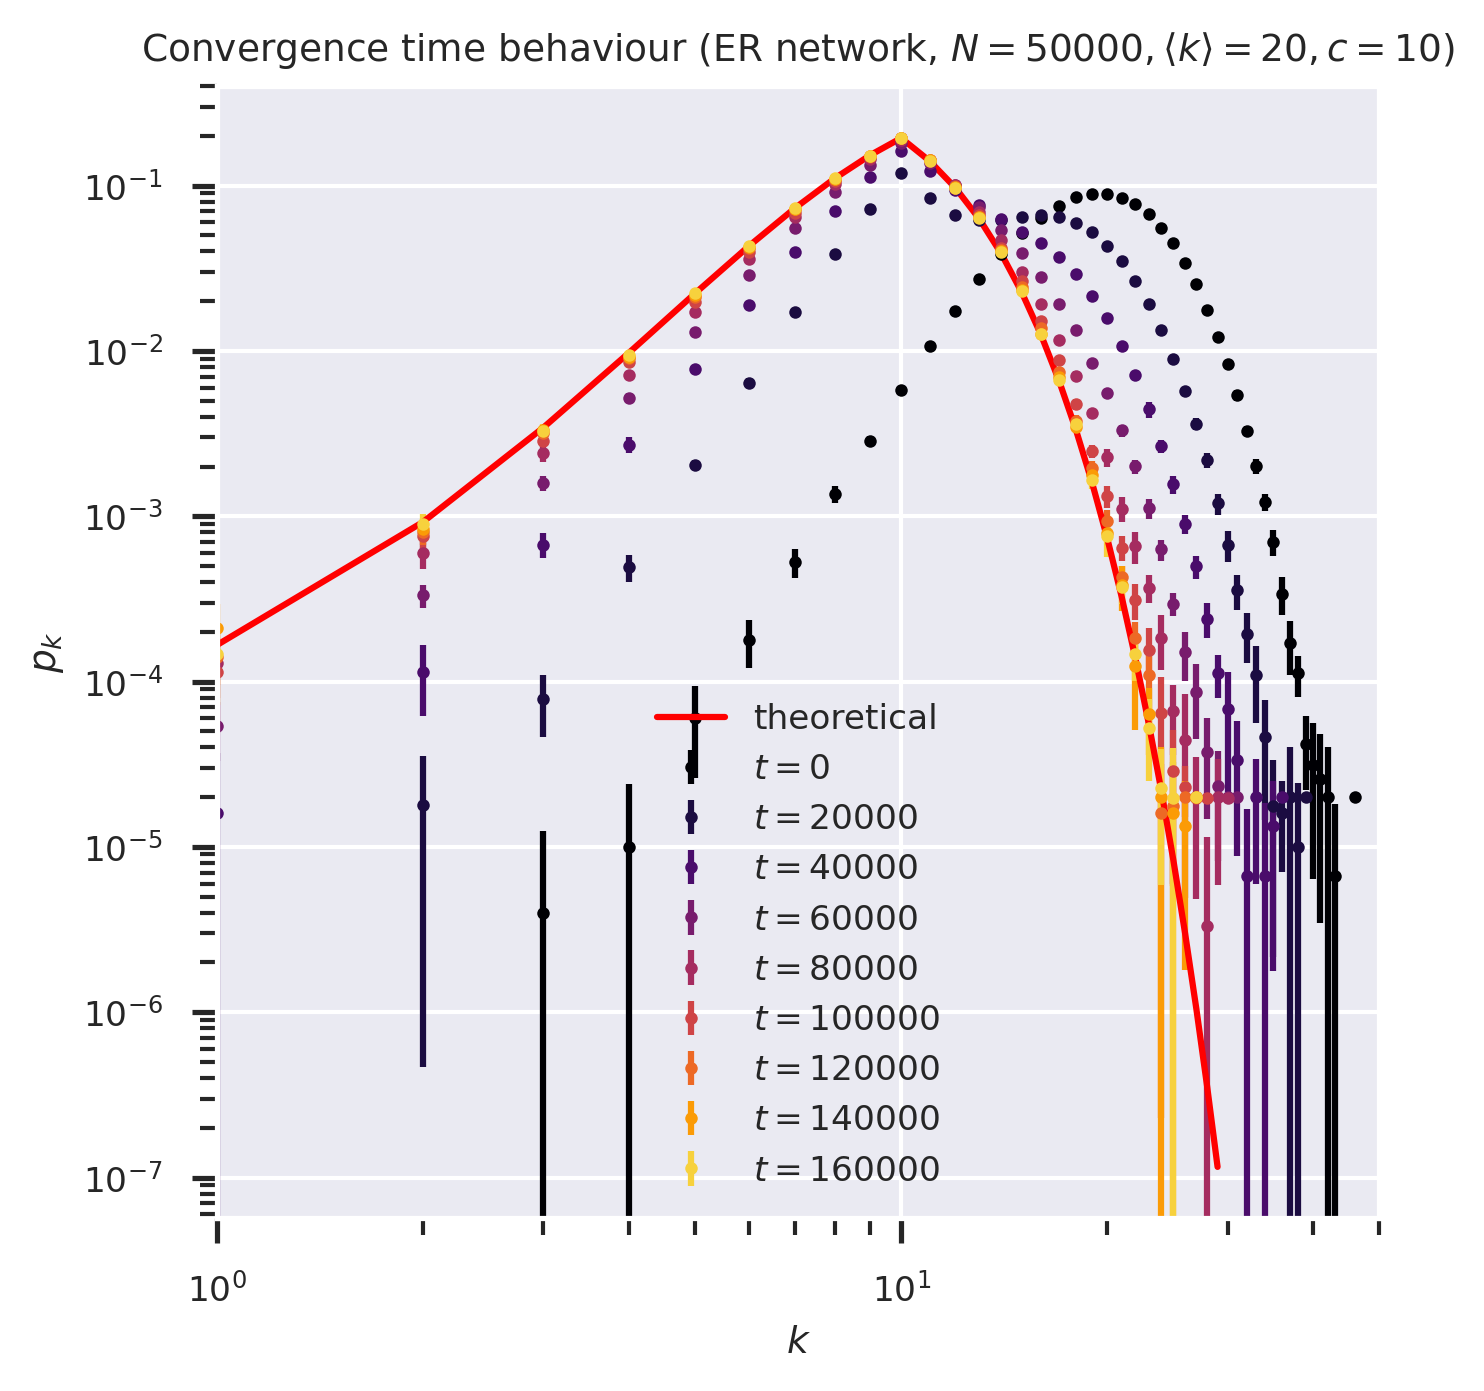

In [16]:
fig = plt.figure(figsize=(5,5))

ks = range(1, 30)

# theoretical
gf = gf_add_delete(c)
plt.plot(ks, list(map(lambda k: gf[k], ks)), 'r-', label='theoretical')

# empirical
colourMap = get_cmap('inferno')
nb.select('er')
df = lab.dataframe()
ots = df.iloc[0][SampleDistribution.OBSERVATIONS]  # all at the same points
for i in range(len(ots)):
    t = ots[i]
    pks, maxk = distributionAtTime(df, t)
    
    # plot observed data
    pkmean, pkerr = pks.mean(), pks.std()
    col = colourMap(i / len(ots))
    plt.errorbar(list(range(maxk)), list(pkmean), yerr=list(pkerr),
                 fmt='.', color=col,
                 label=f'$t={t:.0f}$')

plt.ylabel('$p_k$')
plt.yscale('log')
plt.xlabel('$k$')
plt.xscale('log')
plt.xlim([1, 50])
plt.legend(loc='lower center')
plt.title(f'Convergence time behaviour (ER network, $N = {N}, \\langle k \\rangle = {kmean}, c = {c}$)')

_ = plt.show()